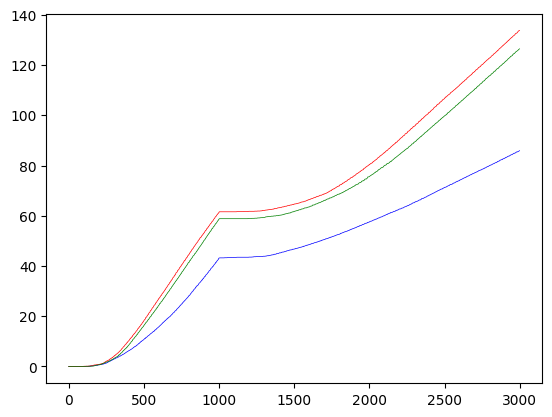

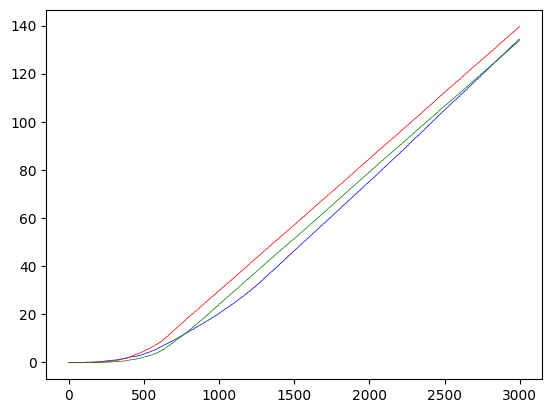

In [26]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

class BlockingMaze:
    def __init__(self) -> None:
        self.height = 6
        self.width = 9
        self.obstacles_before = {
            (2,0),
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
        }
        self.obstacles_after = {
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
            (2,8),
        }
        self.start = (0,3)
        self.target = (5,8)
        self.pos = self.start

    def state_shape(self):
        return (self.height, self.width)
    
    def action_shape(self):
        return 4
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action, num_steps):
        #if self.pos == self.target:
            #self.pos = self.start
            #return False, 1, self.pos
        y = self.pos[0]
        x = self.pos[1]
        match action:
            case 0:#up
                y = min(y + 1, self.height - 1)
            case 1:#down
                y = max(y - 1, 0)
            case 2:#right
                x = min(x + 1, self.width - 1)
            case 3:#left
                x = max(x - 1, 0)
        obstacles = self.obstacles_before if num_steps < 1000 else self.obstacles_after
        if (y,x) not in obstacles:
            self.pos = (y,x)
        #return False, 0, self.pos
        terminated, reward = (True, 1) if self.pos == self.target else (False, 0)
        return terminated, reward, self.pos


class ShortcutMaze:
    def __init__(self) -> None:
        self.height = 6
        self.width = 9
        self.obstacles_before = {
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
            (2,8),
        }
        self.obstacles_after = {
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
        }
        self.start = (0,3)
        self.target = (5,8)
        self.pos = self.start

    def state_shape(self):
        return (self.height, self.width)
    
    def action_shape(self):
        return 4
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action, num_steps):
        #if self.pos == self.target:
            #self.pos = self.start
            #return False, 1, self.pos
        y = self.pos[0]
        x = self.pos[1]
        match action:
            case 0:#up
                y = min(y + 1, self.height - 1)
            case 1:#down
                y = max(y - 1, 0)
            case 2:#right
                x = min(x + 1, self.width - 1)
            case 3:#left
                x = max(x - 1, 0)
        obstacles = self.obstacles_before if num_steps < 1000 else self.obstacles_after
        if (y,x) not in obstacles:
            self.pos = (y,x)
        #return False, 0, self.pos
        terminated, reward = (True, 1) if self.pos == self.target else (False, 0)
        return terminated, reward, self.pos



class Model:
    def __init__(self) -> None:
        self.model = {}

    def update(self, state, action, reward, next_state):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)

    def sample(self):
        #state = random.sample(list(self.model.keys()),1)[0]
        #action = random.sample(list(self.model[state]),1)[0]
        state = list(self.model.keys())[np.random.choice(len(self.model))]
        action = list(self.model[state])[np.random.choice(len(self.model[state]))]
        reward, next_state = self.model[state][action]
        return state, action, reward, next_state

class Model_Plus:
    def __init__(self, k, num_actions) -> None:
        self.k = k
        self.num_actions = num_actions
        self.model = {}

    def update(self, state, action, reward, next_state, cur_step):
        if state not in self.model:
            self.model[state] = {}
            for a in range(self.num_actions):
                self.model[state][a] = (0, state, 0)
        self.model[state][action] = (reward, next_state, cur_step)

    def sample(self, cur_step):
        state = list(self.model.keys())[np.random.choice(len(self.model))]
        action = list(self.model[state])[np.random.choice(len(self.model[state]))]
        reward, next_state, prev_step = self.model[state][action]
        bonus = self.k * math.sqrt(cur_step - prev_step)
        #self.model[state][action] = (reward, next_state, cur_step)
        return state, action, reward, next_state, bonus
    
    def calc_bonus(self, state, action, cur_step):
        if state in self.model:
            prev_step = self.model[state][action][2]
        else:
            prev_step = 0
        bonus = self.k * math.sqrt(cur_step - prev_step)
        return bonus

def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        m = qs.max()
        indices = [i for i in range(len(qs)) if m == qs[i]]
        return np.random.choice(indices)#slow
        #return qs.argmax()
    

def dyna_q(env, num_steps, planning_steps, alpha = 1.0, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model()
    reward_stat = np.zeros(num_steps)
    step = 0
    acc_rewards = 0
    while step < num_steps:
        state = env.reset()
        while step < num_steps:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action,step)
            model.update(state, action, reward, next_state)
            acc_rewards += reward
            #v_prime = 0 if terminated else qs[next_state].max()
            v_prime = qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            for _ in range(planning_steps):
                s, a, r, n = model.sample()
                v_prime = qs[n].max()
                qs[s][a] += (r + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            reward_stat[step] = acc_rewards
            step += 1
            if terminated:
                break
    return reward_stat


def dyna_q_plus(env, num_steps, planning_steps, k, alpha = 1.0, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model_Plus(k,action_shape)
    reward_stat = np.zeros(num_steps)
    step = 0
    acc_rewards = 0
    while step < num_steps:
        state = env.reset()
        while step < num_steps:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action,step)
            model.update(state, action, reward, next_state, step)
            acc_rewards += reward
            #v_prime = 0 if terminated else qs[next_state].max()
            v_prime = qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            for _ in range(planning_steps):
                s, a, r, n, b = model.sample(step)
                v_prime = qs[n].max()
                qs[s][a] += (r + b + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            reward_stat[step] = acc_rewards
            step += 1
            if terminated:
                break
    return reward_stat


def epsilon_greedy_experiment(qs, epsilon, model, state, step):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        values = np.zeros(len(qs))
        for i in range(len(qs)):
            bonus = model.calc_bonus(state, i, step)
            values[i] = qs[i] + bonus
        m = values.max()
        indices = [i for i in range(len(values)) if m == values[i]]
        return np.random.choice(indices)#slow


def dyna_q_plus_experiment(env, num_steps, planning_steps, k, alpha = 1.0, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model_Plus(k,action_shape)
    reward_stat = np.zeros(num_steps)
    step = 0
    acc_rewards = 0
    while step < num_steps:
        state = env.reset()
        while step < num_steps:
            action = epsilon_greedy_experiment(qs[state], epsilon, model, state, step)
            terminated, reward, next_state = env.step(action,step)
            model.update(state, action, reward, next_state, step)
            acc_rewards += reward
            #v_prime = 0 if terminated else qs[next_state].max()
            v_prime = qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            for _ in range(planning_steps):
                s, a, r, n, b = model.sample(step)
                v_prime = qs[n].max()
                qs[s][a] += (r + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            reward_stat[step] = acc_rewards
            step += 1
            if terminated:
                break
    return reward_stat


def test(env, num_steps):
    num_repetitions = 20
    avg_reward_stat = np.zeros((3, num_steps))

    for n in range(num_repetitions):
        np.random.seed(n)
        reward_stat = dyna_q(env, num_steps, 10)
        avg_reward_stat[0] += reward_stat
        np.random.seed(n)
        reward_stat = dyna_q_plus(env, num_steps, 10, 1e-4)
        avg_reward_stat[1] += reward_stat
        np.random.seed(n)
        reward_stat = dyna_q_plus_experiment(env, num_steps, 10, 1e-4)
        avg_reward_stat[2] += reward_stat
    avg_reward_stat /= num_repetitions
    plt.plot(range(num_steps), avg_reward_stat[0], 'b', linewidth = 0.5)
    plt.plot(range(num_steps), avg_reward_stat[1], 'r', linewidth = 0.5)
    plt.plot(range(num_steps), avg_reward_stat[2], 'g', linewidth = 0.5)
    plt.show()

test(BlockingMaze(),3000)
test(ShortcutMaze(),3000)
